<ipython-input-3-6c857fee45a5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_out['is_holiday'] = subset_out['Processed_date'].apply(lambda x: int(x in belgium_holidays))
<ipython-input-3-6c857fee45a5>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_out['day_of_week'] = subset_out['Processed_date'].dt.dayofweek
<ipython-input-3-6c857fee45a5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

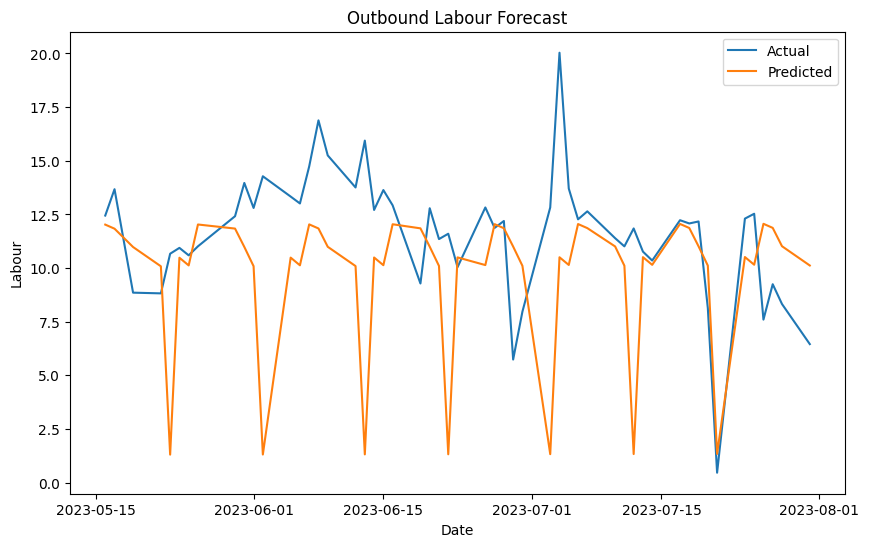

MAE for outbound dataset: 3.124190970029412
MAE for inbound dataset: 7.142937583092478
RMSE for outbound dataset: 4.683977790395632
RMSE for inbound dataset: 8.74693473338244


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import holidays
import os

# Loading datasets

df_out = pd.read_excel('Daily outbound.xlsx')
df_in = pd.read_excel('Daily inbound.xlsx')
# Rest of your preprocessing and modeling code...

# Preprocess outbound data
df_out['Processed_date'] = pd.to_datetime(df_out['Processed_date'])
mask_out = df_out['Processed_date'] >= '2022-08-01'
subset_out = df_out[mask_out]

# Preprocess inbound data
df_in['Date'] = pd.to_datetime(df_in['Date'])
subset_in = df_in.copy()

# Define holidays for Belgium
belgium_holidays = holidays.BE()

# Add holiday indicator for outbound dataset
subset_out['is_holiday'] = subset_out['Processed_date'].apply(lambda x: int(x in belgium_holidays))
subset_out['day_of_week'] = subset_out['Processed_date'].dt.dayofweek
subset_out['month'] = subset_out['Processed_date'].dt.month

# Add day of week and month for inbound dataset
subset_in['day_of_week'] = subset_in['Date'].dt.dayofweek
subset_in['month'] = subset_in['Date'].dt.month

# Split datasets into training and test sets
train_out = subset_out.iloc[:int(0.8 * len(subset_out))]
test_out = subset_out.iloc[int(0.8 * len(subset_out)):]

train_in = subset_in.iloc[:int(0.8 * len(subset_in))]
test_in = subset_in.iloc[int(0.8 * len(subset_in)):]

# Initialize Prophet models
prophet_out = Prophet()
prophet_in = Prophet()

# Fit Prophet models
prophet_out.fit(train_out[['Processed_date', 'Calculated Labour', 'is_holiday', 'day_of_week', 'month']].rename(columns={'Processed_date': 'ds', 'Calculated Labour': 'y'}))
prophet_in.fit(train_in[['Date', 'Calculated_Labour', 'day_of_week', 'month']].rename(columns={'Date': 'ds', 'Calculated_Labour': 'y'}))

# Make forecasts
future_out = prophet_out.make_future_dataframe(periods=len(test_out))
forecast_out = prophet_out.predict(future_out)

future_in = prophet_in.make_future_dataframe(periods=len(test_in))
forecast_in = prophet_in.predict(future_in)

# Evaluate forecasts
mae_out = mean_absolute_error(test_out['Calculated Labour'], forecast_out['yhat'][-len(test_out):])
mae_in = mean_absolute_error(test_in['Calculated_Labour'], forecast_in['yhat'][-len(test_in):])

mse_out = mean_squared_error(test_out['Calculated Labour'], forecast_out['yhat'][-len(test_out):])
rmse_out = np.sqrt(mse_out)

mse_in = mean_squared_error(test_in['Calculated_Labour'], forecast_in['yhat'][-len(test_in):])
rmse_in = np.sqrt(mse_in)

# Visualize forecasts (adjust for outbound and inbound accordingly)
plt.figure(figsize=(10, 6))
plt.plot(test_out['Processed_date'], test_out['Calculated Labour'], label='Actual')
plt.plot(test_out['Processed_date'], forecast_out['yhat'][-len(test_out):], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Labour')
plt.title('Outbound Labour Forecast')
plt.legend()
plt.show()

# Display evaluation metrics
print(f"MAE for outbound dataset: {mae_out}")
print(f"MAE for inbound dataset: {mae_in}")
print(f"RMSE for outbound dataset: {rmse_out}")
print(f"RMSE for inbound dataset: {rmse_in}")


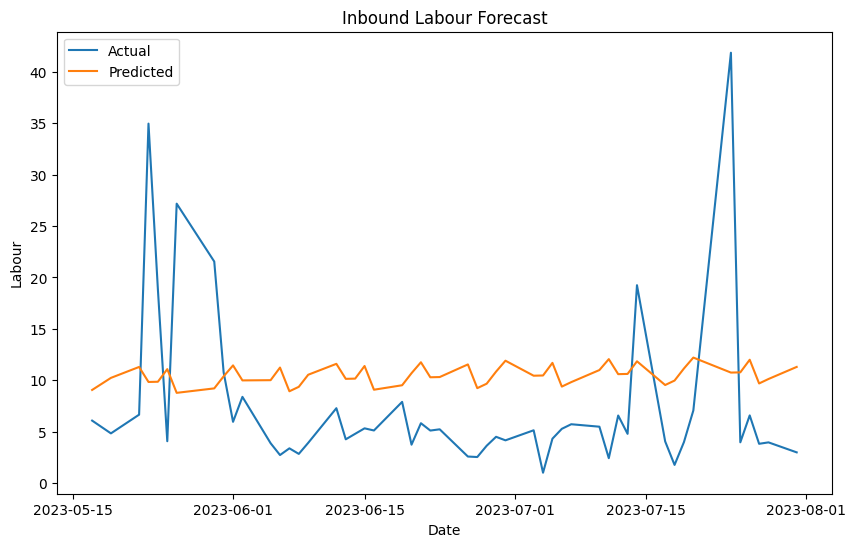

In [ ]:
# Visualize forecasts (adjust for outbound and inbound accordingly)
plt.figure(figsize=(10, 6))
plt.plot(test_in['Date'], test_in['Calculated_Labour'], label='Actual')
plt.plot(test_in['Date'], forecast_in['yhat'][-len(test_in):], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Labour')
plt.title('Inbound Labour Forecast')
plt.legend()
plt.show()

**1. MAE (Mean Absolute Error):**

*Outbound Dataset* (3.12): On average, the predictions for outbound 'Labour' are about 3.12 units off from the actual values. It measures the average magnitude of errors between predicted and actual values, regardless of their direction (positive or negative).

*Inbound Dataset* (7.14): For inbound 'Labour', the average difference between predicted and actual values is around 7.14 units.

**2. RMSE (Root Mean Squared Error):**

*Outbound Dataset *(4.68): RMSE measures the square root of the average of squared differences between predicted and actual values. It penalizes larger errors more than MAE. In this case, the RMSE for outbound 'Labour' is approximately 4.68 units.

*Inbound Dataset *(8.75): Similarly, for inbound 'Labour', the RMSE is around 8.75 units, indicating the magnitude of errors between predicted and actual values, considering the squared differences.

In essence, both MAE and RMSE provide measures of the model's accuracy in predicting 'Labour'. Lower values for both metrics indicate better performance, suggesting that the model is closer on average to the actual values in the dataset. However, RMSE is more sensitive to larger errors compared to MAE.

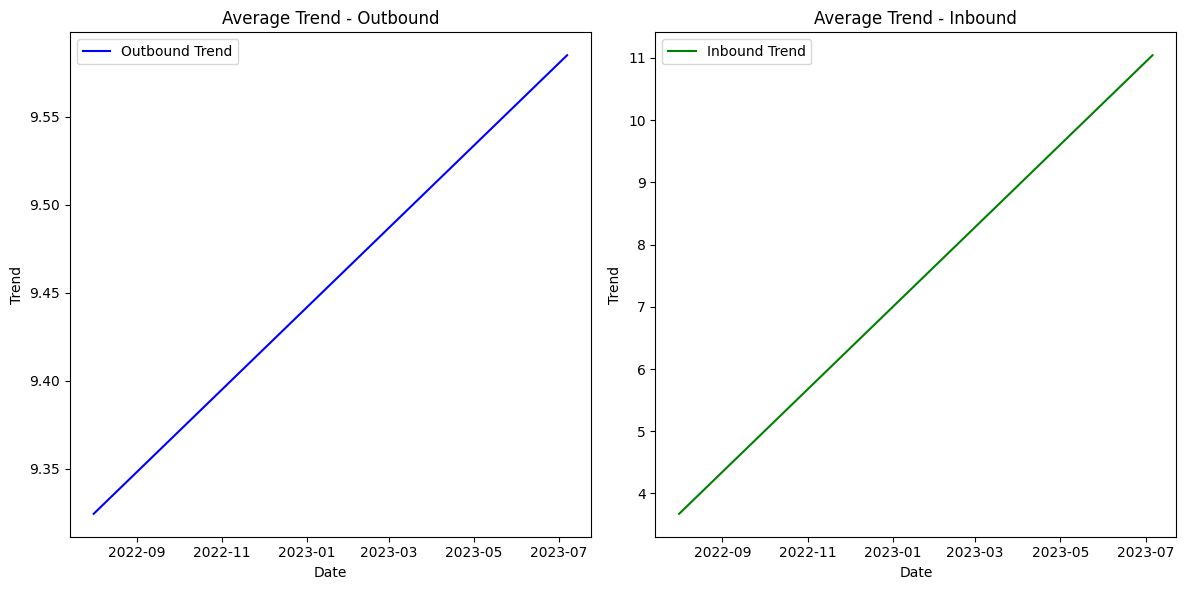

In [ ]:
# Make forecasts
future_out = prophet_out.make_future_dataframe(periods=len(test_out))
forecast_out = prophet_out.predict(future_out)

future_in = prophet_in.make_future_dataframe(periods=len(test_in))
forecast_in = prophet_in.predict(future_in)

# Extract trend components for outbound dataset
trend_out = prophet_out.predict(future_out)[['ds', 'trend']]

# Extract trend components for inbound dataset
trend_in = prophet_in.predict(future_in)[['ds', 'trend']]

# Visualize the average trends for outbound and inbound datasets
plt.figure(figsize=(12, 6))

# Plot outbound trend
plt.subplot(1, 2, 1)
plt.plot(trend_out['ds'], trend_out['trend'], label='Outbound Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Average Trend - Outbound')
plt.legend()

# Plot inbound trend
plt.subplot(1, 2, 2)
plt.plot(trend_in['ds'], trend_in['trend'], label='Inbound Trend', color='green')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Average Trend - Inbound')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Make forecasts for outbound dataset
future_out = prophet_out.make_future_dataframe(periods=len(test_out))
forecast_out = prophet_out.predict(future_out)

# Make forecasts for inbound dataset
future_in = prophet_in.make_future_dataframe(periods=len(test_in))
forecast_in = prophet_in.predict(future_in)

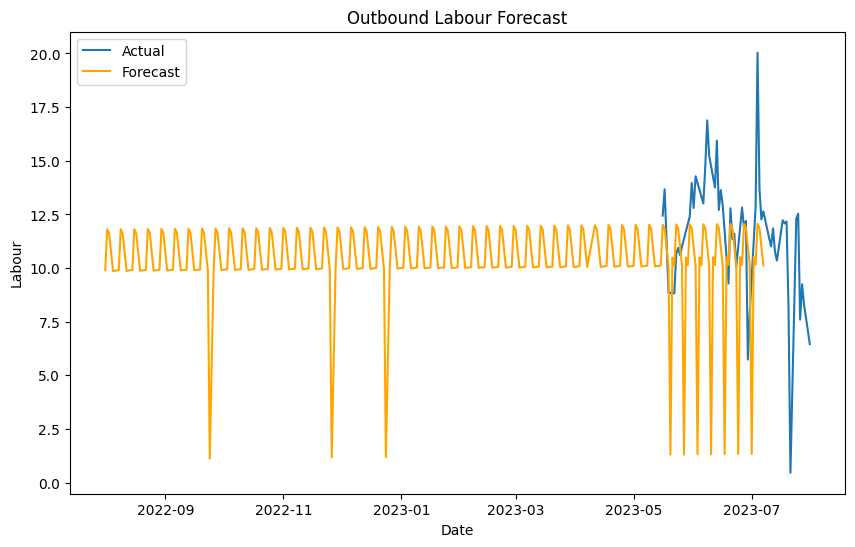

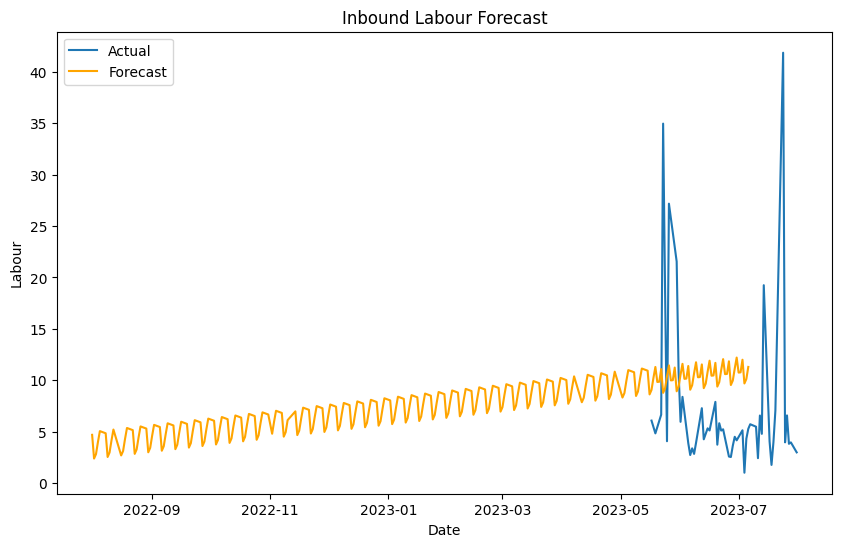

In [ ]:
# Visualize forecasts for outbound dataset
plt.figure(figsize=(10, 6))
plt.plot(test_out['Processed_date'], test_out['Calculated Labour'], label='Actual')
plt.plot(forecast_out['ds'], forecast_out['yhat'], label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Labour')
plt.title('Outbound Labour Forecast')
plt.legend()
plt.show()

# Visualize forecasts for inbound dataset
plt.figure(figsize=(10, 6))
plt.plot(test_in['Date'], test_in['Calculated_Labour'], label='Actual')
plt.plot(forecast_in['ds'], forecast_in['yhat'], label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Labour')
plt.title('Inbound Labour Forecast')
plt.legend()
plt.show()


In [ ]:
# Extend future dataframe for outbound dataset by 6 months
future_out_extended = prophet_out.make_future_dataframe(periods=180)  # 180 days = 6 months
forecast_out_extended = prophet_out.predict(future_out_extended)

# Extend future dataframe for inbound dataset by 6 months
future_in_extended = prophet_in.make_future_dataframe(periods=180)  # 180 days = 6 months
forecast_in_extended = prophet_in.predict(future_in_extended)


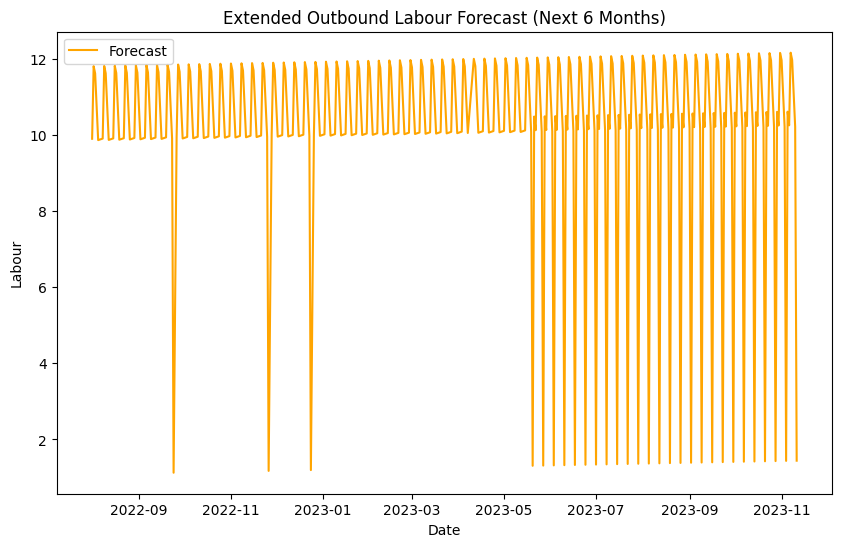

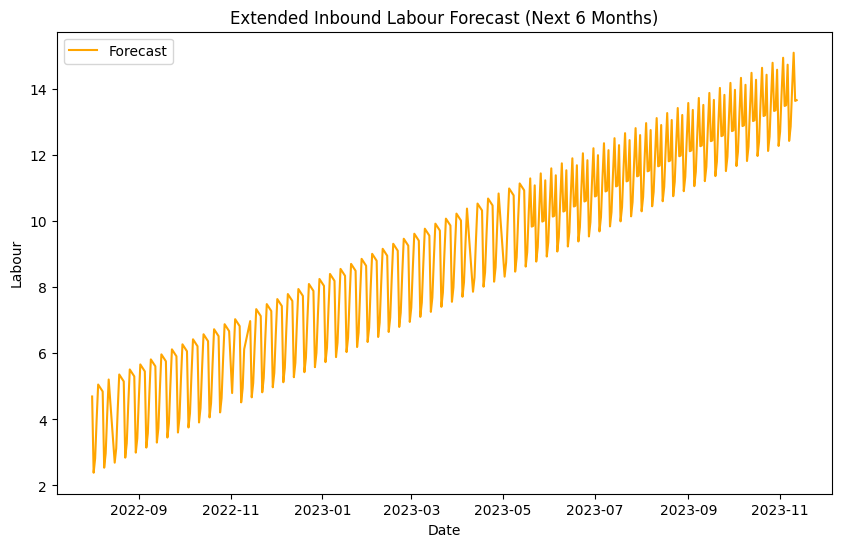

In [ ]:
# Visualize extended forecasts for outbound dataset
plt.figure(figsize=(10, 6))
plt.plot(forecast_out_extended['ds'], forecast_out_extended['yhat'], label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Labour')
plt.title('Extended Outbound Labour Forecast (Next 6 Months)')
plt.legend()
plt.show()

# Visualize extended forecasts for inbound dataset
plt.figure(figsize=(10, 6))
plt.plot(forecast_in_extended['ds'], forecast_in_extended['yhat'], label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Labour')
plt.title('Extended Inbound Labour Forecast (Next 6 Months)')
plt.legend()
plt.show()
